In [2]:
import numpy as np

# QC-related libraries
from qiskit import Aer, IBMQ, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# from qiskit.tools.visualization import plot_histogram
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes

from docplex.mp.model import Model
from qiskit.optimization.applications.ising.docplex import get_operator

In [3]:
def not_in_edge( n, Edge ):
    set_edge = set()
    for i in range( n ):
        for k in range( n ):
            if ( i, k ) in Edge or ( k, i ) in Edge:
                continue
            else:
                set_edge.add( ( i, k ) )
    return set_edge

# Hamiltonian-Cycle Problem

### Generating a graph

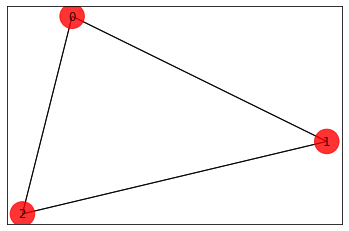

In [13]:
Vertex = { 0, 1, 2 }
Edge   = {(0,1), (1,2), (2,0) }

n      = len(Vertex)
G = nx.Graph()
G.add_nodes_from( np.arange( 0, n ) )
eList = list( Edge )  # (i,j): edge
G.add_edges_from( eList )

colors = [ 'r' for node in G.nodes() ]
pos = nx.spring_layout( G )

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    nx.draw_networkx_edges(G, pos=pos )

draw_graph(G, colors, pos)

### Creating a docplex model

In [14]:
# Create an instance of a model and variables with DOcplex.
mdl = Model( name='HamiltonCycle' )
x = { ( i, p ): mdl.binary_var( name= 'x_{0}_{1}'.format( i, p ) ) for i in range( n ) for p in range( n ) }

# Generate cost funciton
P1 = 0
P2 = 0
H  = 0

for i in range(n):
    P1 += ( 1 - mdl.sum( x[(i,j)] for j in range(n) ) ) ** 2

for j in range(n):
    P2 += ( 1 - mdl.sum( x[(i,j)] for i in range(n) ) ) ** 2

for ( i1, i2 ) in not_in_edge( n, Edge ):
    H += x[(i1,0)] * x[(i2,n-1)]
    H += mdl.sum( x[(i1,j)] * x[(i2,j+1)] for j in range(n-1) )

HamiltonCycleFunc = H + P1 + P2 # Set HamiltonCycleFunc to be minimized

mdl.minimize( HamiltonCycleFunc )

### Mapping to the Ising problem

Qiskit provides functionality to directly generate the Ising Hamiltonian as well as create the corresponding `QuadraticProgrm`

In [15]:
qubitOp, offset = get_operator(mdl)
print('Offset:', offset)
# print('Ising Hamiltonian:')
# print(qubitOp.print_details())

Offset: 8.25


In [16]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
#qp.to_docplex().prettyprint()

In [17]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: 0.0
optimal value: [1. 0. 0. 0. 0. 1. 0. 1. 0.]
status: SUCCESS


Since the problem was cast to a minimization problem, the solution of `0.0` corresponds to the optimum.

### Checking that the full Hamiltonian gives the right cost

In [18]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('hamiltonian-cycle objective:', result.eigenvalue.real + offset)

energy: -8.25
hamiltonian-cycle objective: 0.0


### Running it on quantum computer

We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with $Y$ single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [19]:
provider = IBMQ.load_account()
simulator_backend = provider.get_backend("ibmq_qasm_simulator")
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(simulator_backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-02-19 03:36:10,263: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# construct VQE
spsa = SPSA(maxiter=1000)
ansatz = TwoLocal( qubitOp.num_qubits, rotation_blocks='ry', entanglement_blocks='cx', reps=2, entanglement='linear' )

vqe = VQE(operator=qubitOp, var_form=ansatz, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run()

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('hamiltonian-cycle objective:', result.eigenvalue.real + offset)
print('solution:', x)

In [ ]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)